____

### Table of contents

* [Analysis Goals](#Goals)
* [Set Up](#Set-Up)
* [Data Upload](#Data-upload-and-handling)


1. [State of the Union from 1900: number of sentiment-associated words](#1.-State-of-the-Union-from-1900:-number-of-sentiment-associated-words)
2. [State of the Union from 1900: most frequent sentiment-associated words](#2.-State-of-the-Union-from-1900:-most-frequent-sentiment-associated-words)
3. [State of the Union from 1900: most frequent bigrams](#3.-State-of-the-Union-from-1900:-most-frequent-bigrams)
4. [State of the Union from 1900: sentiment analysis](#4.-State-of-the-Union-from-1900:-sentiment-analysis)
5. [Focus on the last 4 presidents: top 5 words in each address](#5.-Focus-on-the-last-4-presidents:-top-5-words-in-each-address)
6. [Focus on the last 4 presidents: most frequent bigrams](#6.-Focus-on-the-last-4-presidents:-Most-frequent-bigrams-by-wordclouds)

____

# Goals

### The purpose is to perform a simple sentiment analysis on the State of the Union address from 2000 to 2018. The State of the Union is a speech given once a year from the President of the United States. 





## Set Up

In [1]:
# load in the libraries we'll need
library(tidyverse)
library(tidytext)
library(textdata)
library(glue)
library(stringr)
library(wordcloud)
library(stringr)
library(gridExtra)

options(stringsAsFactors=FALSE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: RColorBrewer


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




Functions

* GetTokens: to get tokens from each speech text
* GetBigrams: to get tokens from each speech text

In [2]:
# write a function that takes the name of a file and returns the # of postive
# sentiment words, negative sentiment words, the difference & the normalized difference
GetTokens <- function(file){
    # get the file
    fileName <- glue("../input/", file, sep = "")
    # get rid of any sneaky trailing spaces
    fileName <- trimws(fileName)

    # read in the new file
    fileText <- glue(read_file(fileName))
    # remove any dollar signs (they're special characters in R)
    fileText <- gsub("\\$", "", fileText) 

    # tokenize
    tokens <- data_frame(text = fileText) %>% unnest_tokens(word, text)
    tokens$Speech <- file
    tokens$President <- unlist(strsplit(tokens$Speech, '_'))[1]
    Year <- unlist(strsplit(tokens$Speech, '_'))[2]
    Year <- gsub('.txt', '', Year)
    Year <- as.numeric(Year)
    #print(Year)
    tokens$Year <- Year
    return(tokens)}

In [3]:
data("stop_words")

GetBigrams <- function(file){
    # get the file
    fileName <- glue("../input/", file, sep = "")
    # get rid of any sneaky trailing spaces
    fileName <- trimws(fileName)

    # read in the new file
    fileText <- glue(read_file(fileName))
    # remove any dollar signs (they're special characters in R)
    fileText <- gsub("\\$", "", fileText) 

    # tokenize
    tokens <- data_frame(text = fileText) %>% unnest_tokens(bigram, text, token='ngrams', n=2)  %>% 
    separate(bigram, c("word1", "word2"), sep = " ") %>% dplyr::filter(!word1 %in% stop_words$word) %>%
    dplyr::filter(!word2 %in% stop_words$word) %>% unite(bigram, word1, word2, sep = " ")
    
    tokens$Speech <- file
    tokens$President <- unlist(strsplit(tokens$Speech, '_'))[1]
    Year <- unlist(strsplit(tokens$Speech, '_'))[2]
    Year <- gsub('.txt', '', Year)
    Year <- as.numeric(Year)
    #print(Year)
    tokens$Year <- Year
    return(tokens)}

#GetBigrams(From1900[1])

## Data upload and handling

From the txt files of each speech, I generate: 

* Tokens List
* Bigrams List
* Sentiments List: positive or negative sentiment value is associated to tokens
* Frequency of sentiment-associated words 
* Frequency of bigrams

In [4]:
AllFiles <- list.files('../input/')
AllFiles <- AllFiles[!(AllFiles %in% 'sotu')]

From1900 <- c(AllFiles[grepl('_19', AllFiles)], AllFiles[grepl('_20', AllFiles)])

ChosenFiles <- c('Clinton_1993','Clinton_1994','Clinton_1995','Clinton_1996','Clinton_1997','Clinton_1998','Clinton_1999','Clinton_2000','Bush_2001',
                 'Bush_2002','Bush_2003','Bush_2004','Bush_2005','Bush_2006','Bush_2007', 'Bush_2008',
    'Obama_2009','Obama_2010','Obama_2011','Obama_2012','Obama_2013','Obama_2014',
                 'Obama_2015','Obama_2016', 'Trump_2017','Trump_2018')

In [5]:
TokenList <- list()

for(i in 1:length(From1900)){
    TokenList[[i]] <- GetTokens(From1900[i])
    names(TokenList)[i] <- sub('.txt', '', From1900[i])
}

#length(TokenList)
    

Warning message:
“`data_frame()` is deprecated as of tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [6]:
# For each word list we associate the sentiment according to
SentimentList <- list()

for(i in 1:length(From1900)){
    SentimentList[[i]] <- TokenList[[i]] %>% inner_join(get_sentiments("bing"), by='word')
    names(SentimentList)[i] <- sub('.txt', '', From1900[i])
}

#SentimentList

In [7]:
FreqList <- list()

for(i in 1:length(From1900)){
    FreqList[[i]] <- SentimentList[[i]] %>% dplyr::count(word, sentiment, Speech, President, Year) %>% arrange(desc(n))
    #FreqList[[i]] <- FreqList[[i]] %>% mutate(Tot=sum(n))
    FreqList[[i]] <- FreqList[[i]] %>% mutate(WordFreq=n/sum(n)*100)
    names(FreqList)[i] <- sub('.txt', '', From1900[i])
}
# FreqList[1] 

In [8]:
BigramList <- list()

for(i in 1:length(From1900)){
    BigramList[[i]] <- GetBigrams(From1900[i])
    names(BigramList)[i] <- sub('.txt', '', From1900[i])
}

#length(BigramList)
#BigramList

In [9]:
FreqBigrams <- list()

for(i in 1:length(From1900)){
    FreqBigrams[[i]] <- BigramList[[i]] %>% dplyr::count(bigram, Speech, President, Year) %>% arrange(desc(n))
    #FreqList[[i]] <- FreqList[[i]] %>% mutate(Tot=sum(n))
    FreqBigrams[[i]] <- FreqBigrams[[i]] %>% mutate(BigramFreq=n/sum(n)*100)
    names(FreqBigrams)[i] <- sub('.txt', '', From1900[i])
}
 #FreqBigrams[[10]] %>% top_n(n, n=10)

## 1. State of the Union from 1900: number of sentiment-associated words



In [10]:
# Total words for each speech

SumWord <- data.frame(Speech=FreqList[[1]]$Speech[1], Tot=sum(FreqList[[1]]$n), 
                      President=FreqList[[1]]$President[1], Year=FreqList[[1]]$Year[1])

for(i in 2:length(FreqList)){
    Temp <- data.frame(Speech=FreqList[[i]]$Speech[1], Tot=sum(FreqList[[i]]$n), 
                      President=FreqList[[i]]$President[1], Year=FreqList[[i]]$Year[1])
    SumWord <- rbind(SumWord, Temp)
}

#SumWord

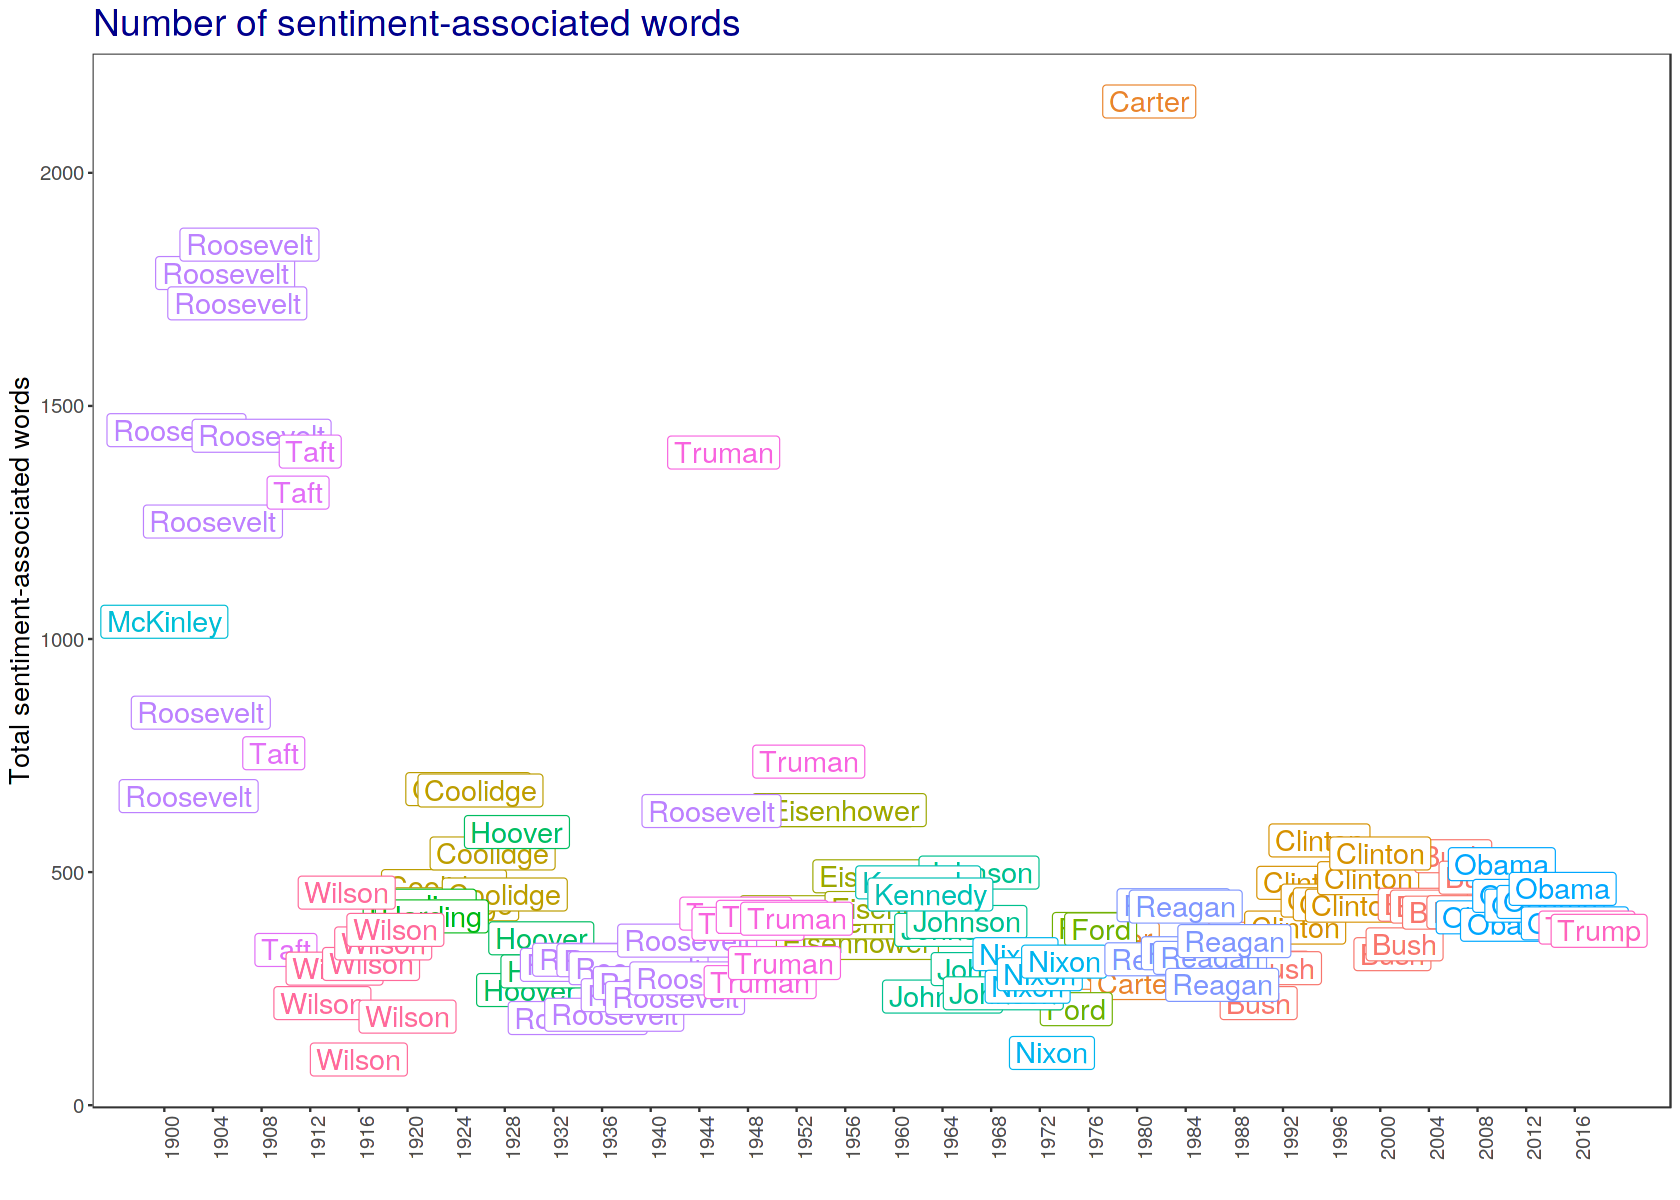

In [11]:
MyTheme <- theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
theme(axis.text.x =element_text(size=12, angle=90), axis.text.y =element_text(size=12),
      axis.title=element_text(size=16)) + 
theme(plot.title = element_text(colour='darkblue', size=22))

options(repr.plot.width=14, repr.plot.height=10)

ggplot(data=SumWord, aes(x=Year, y=Tot, color=President)) +
geom_label(label=SumWord$President, size=6) +
scale_x_continuous(breaks=seq(1900, 2016, by=4)) +
ggtitle('Number of sentiment-associated words') +
ylab('Total sentiment-associated words') + xlab('') +
theme_bw() + MyTheme + theme(legend.position="none")


## 2. State of the Union from 1900: most frequent sentiment-associated words

In [12]:
# Most Frequent sentiment-associated word for each speech

TopWord <- FreqList[[1]] %>% top_n(n, n=1)

for(i in 2:length(FreqList)){
    Temp <- FreqList[[i]] %>% top_n(n, n=1)
    TopWord <- rbind(TopWord, Temp)
}

#TopWord

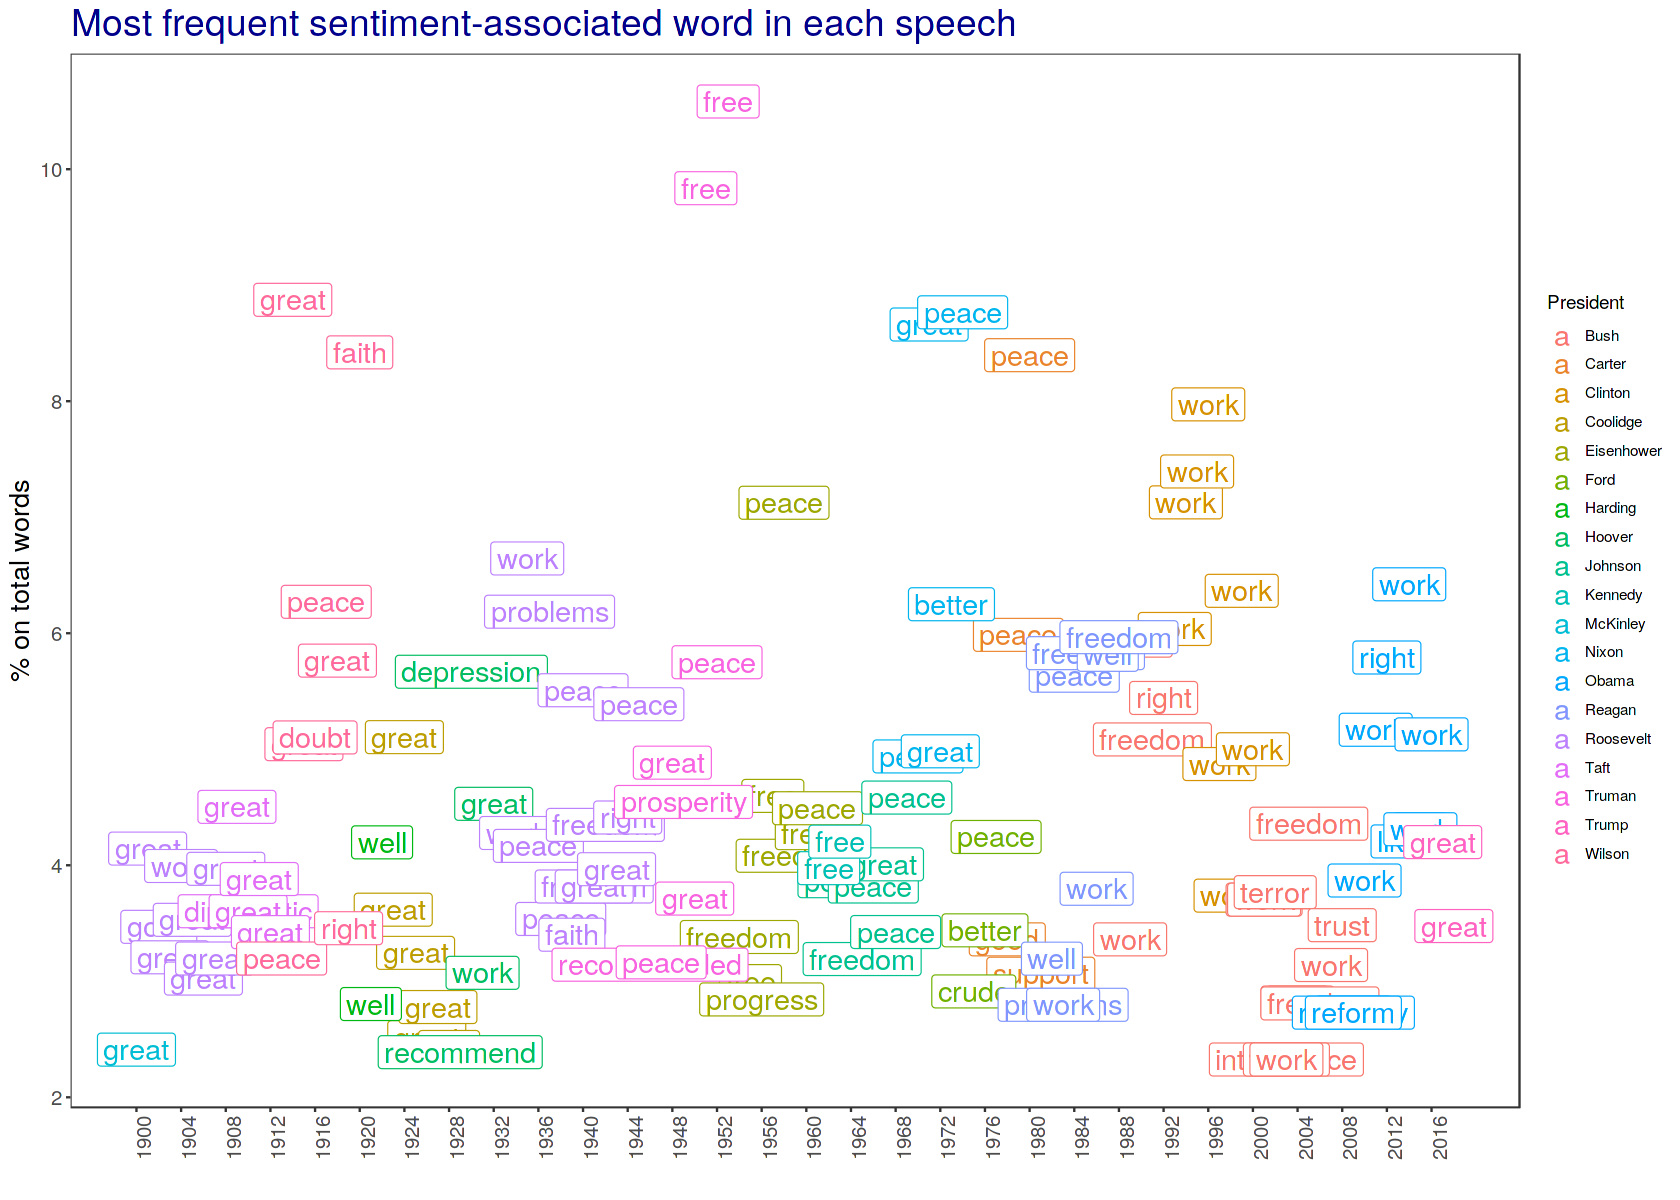

In [13]:
#TopWord

options(repr.plot.width=14, repr.plot.height=10)
#ggplot(data=TopWord, aes(x=Year, y=n, color=President)) +
#geom_label(label=TopWord$word) +
#theme_bw()

ggplot(data=TopWord, aes(x=Year, y=WordFreq, color=President)) +
geom_label(label=TopWord$word, size=6) +
scale_x_continuous(breaks=seq(1900, 2016, by=4)) +
ggtitle('Most frequent sentiment-associated word in each speech') +
ylab('% on total words') + xlab('') +
theme_bw() + MyTheme
#theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
#theme(axis.text.x = element_text(angle=90, size=12))

## 3. State of the Union from 1900: most frequent bigrams

In [14]:
TopBigram <- FreqBigrams[[1]] %>% top_n(n, n=1)

for(i in 2:length(FreqBigrams)){
    Temp <- FreqBigrams[[i]] %>% top_n(n, n=1)
    TopBigram <- rbind(TopBigram, Temp)
}


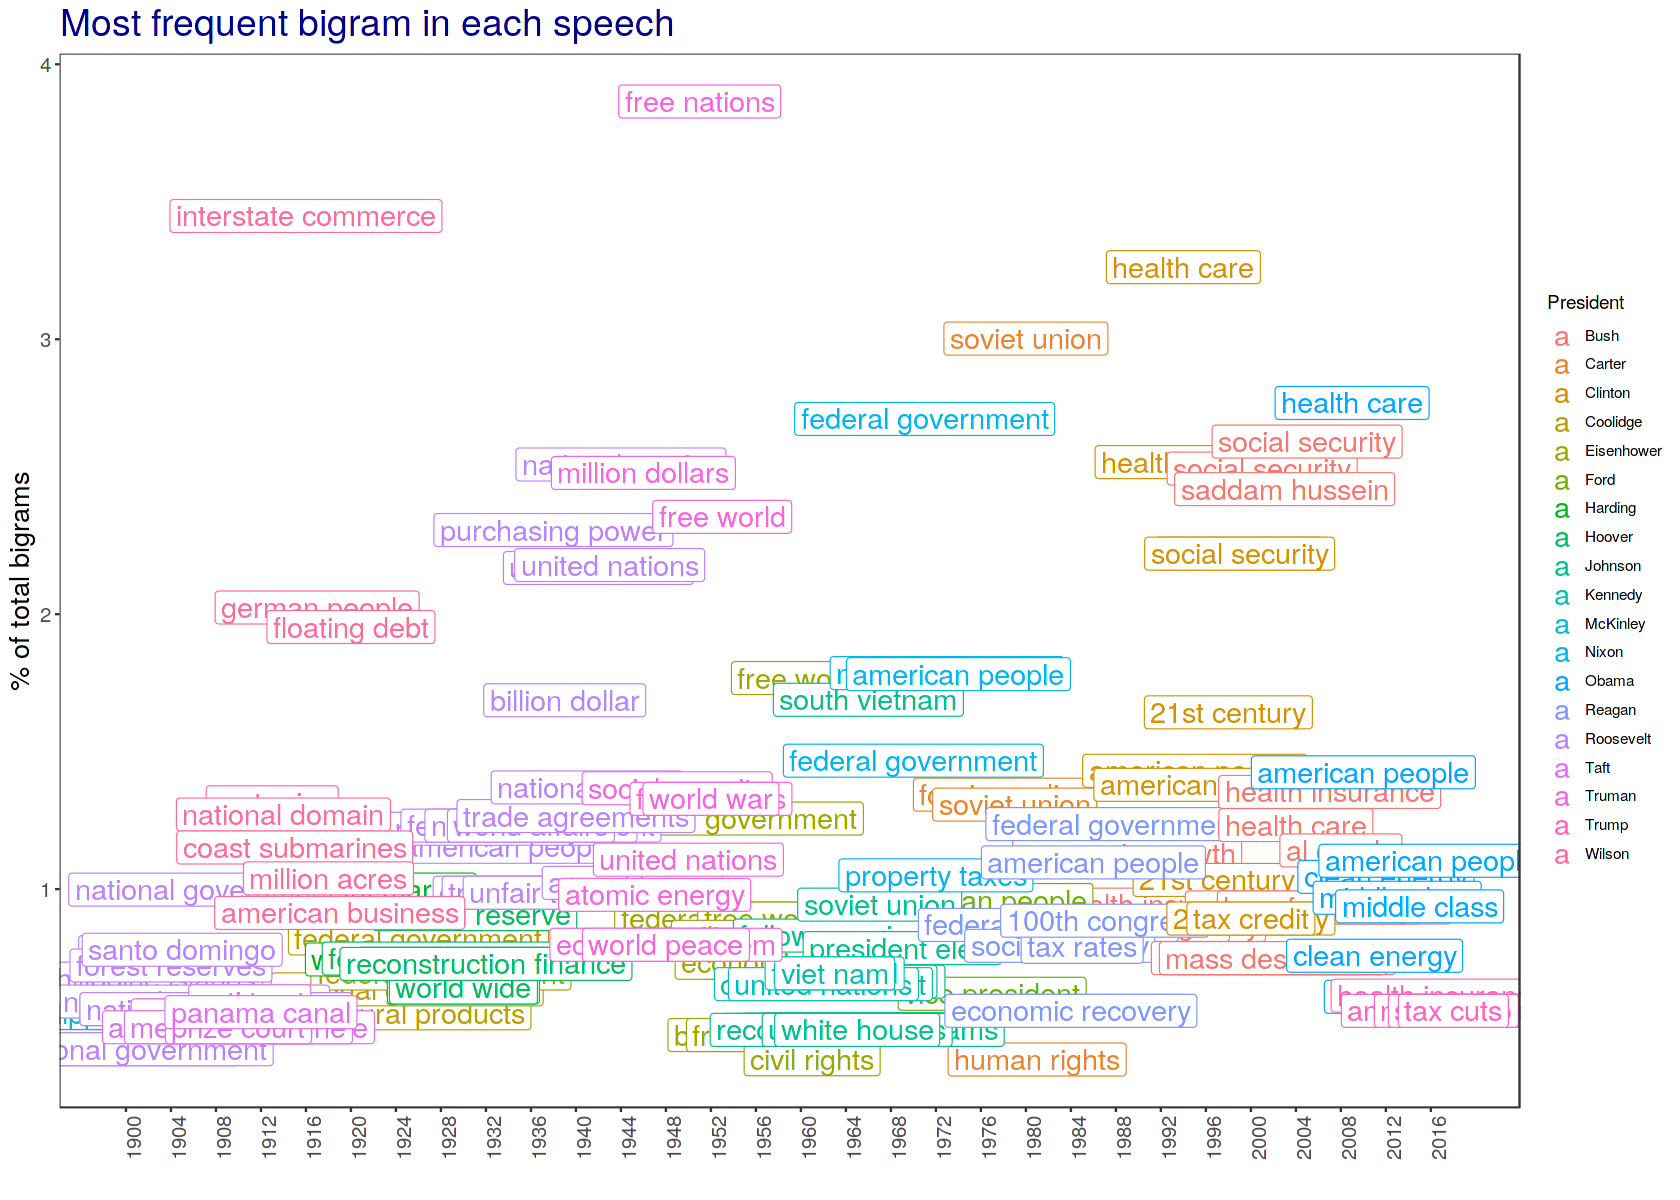

In [15]:
#TopBigrams

options(repr.plot.width=14, repr.plot.height=10)
#ggplot(data=TopWord, aes(x=Year, y=n, color=President)) +
#geom_label(label=TopWord$word) +
#theme_bw()

ggplot(data=TopBigram, aes(x=Year, y=BigramFreq, color=President)) +
geom_label(label=TopBigram$bigram, size=6) +
scale_x_continuous(breaks=seq(1900, 2016, by=4)) +
ggtitle('Most frequent bigram in each speech') +
ylab('% of total bigrams') + xlab('') +
theme_bw() + MyTheme

## 4. State of the Union from 1900: sentiment analysis

For each speech, I calculate the frequency of positive words on total sentiment-associated words.

In [16]:
# Calculate frequency of positive-assoviated words 

SumSentiment <-  SentimentList[[1]] %>% count(sentiment) %>% # count the # of positive & negative words
  spread(sentiment, n, fill = 0) %>% # made data wide rather than narrow
  mutate(PosFreq = round((positive)/(positive + negative)*100)) %>%
  mutate(President=FreqList[[1]]$President[1], Year=FreqList[[1]]$Year[1])  

for(i in 2:length(SentimentList)){
    
    Temp <- SentimentList[[i]] %>% count(sentiment) %>% # count the # of positive & negative words
    spread(sentiment, n, fill = 0) %>% # made data wide rather than narrow
    mutate(PosFreq = round((positive)/(positive + negative)*100)) %>%
    mutate(President=FreqList[[i]]$President[1], Year=FreqList[[i]]$Year[1]) 
    
    SumSentiment <- rbind(SumSentiment, Temp)
}

#SumSentiment

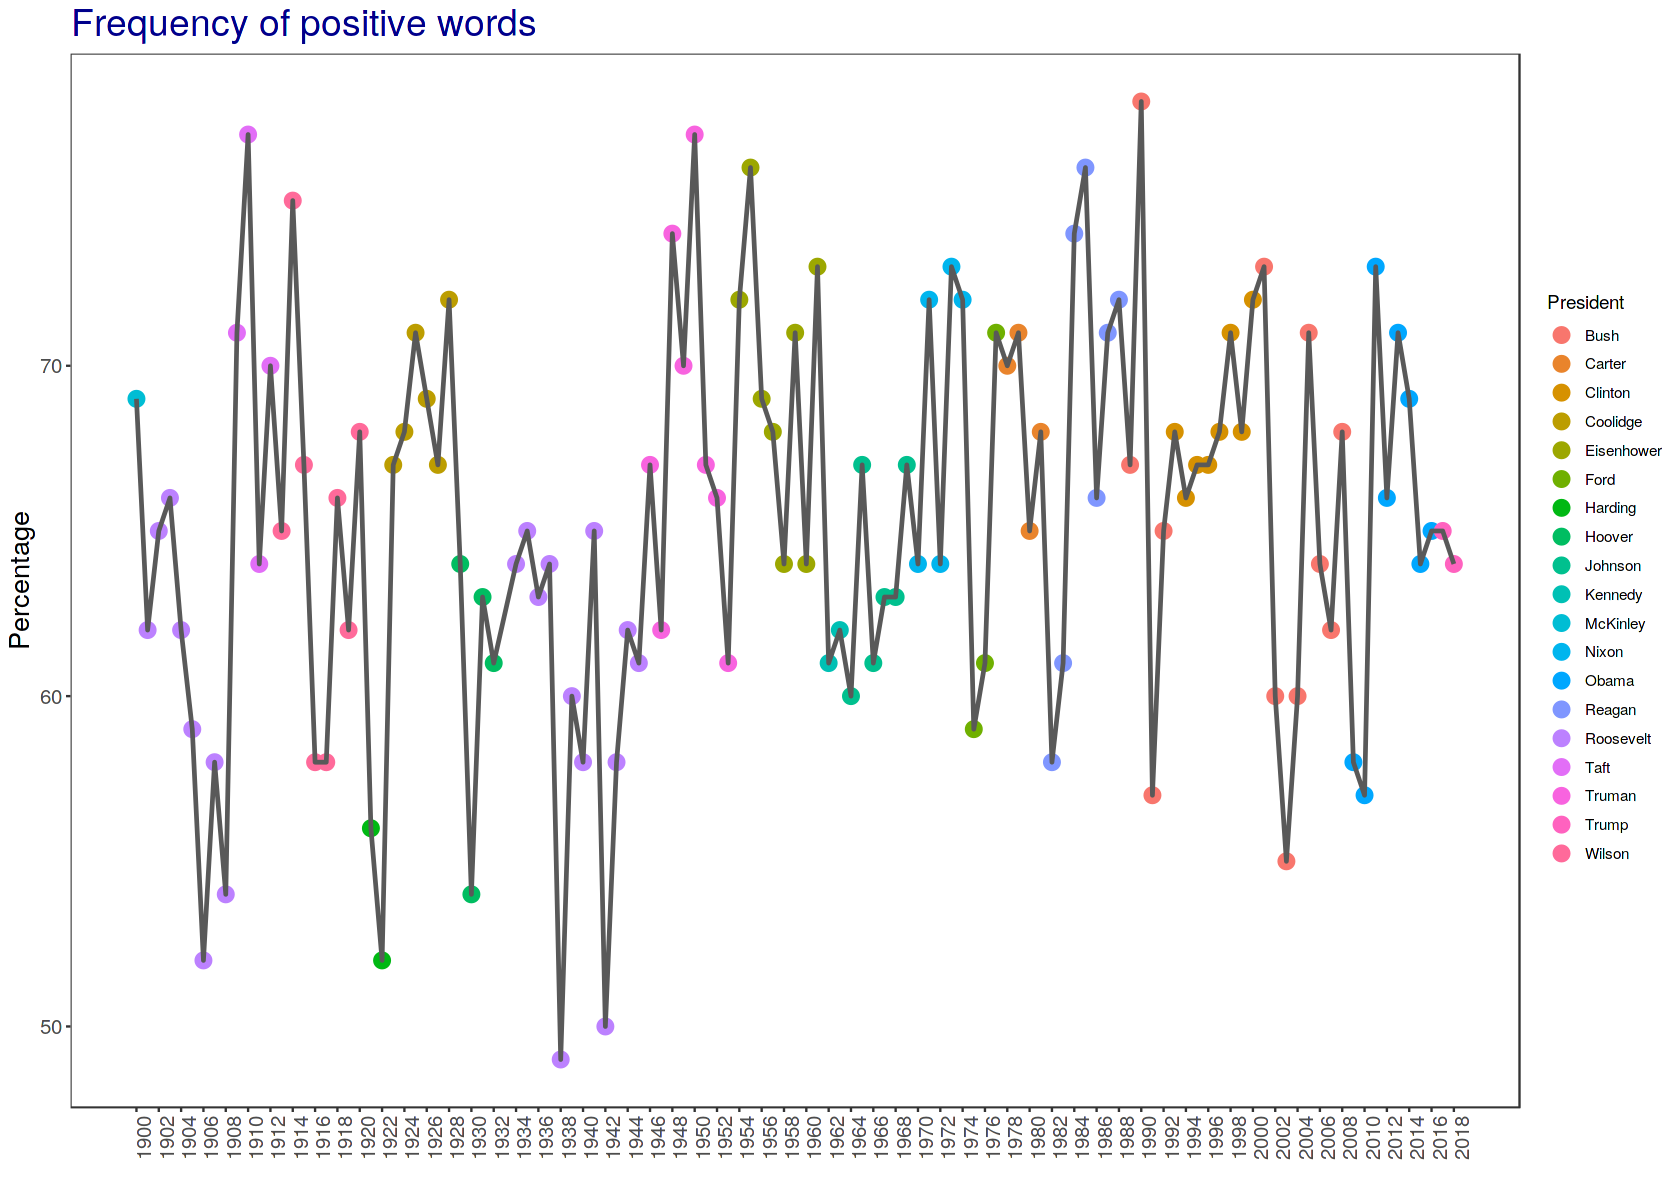

In [17]:
# Scatterplot
ggplot(data=SumSentiment, aes(x=Year, y=PosFreq)) +
geom_point(aes(color=President), size=4) +
geom_line(color='grey35', size=1) +
#geom_text(label=SumSentiment$President, color='blue', size=2.5) +
scale_x_continuous(breaks=seq(1900, 2018, by=2)) +
ggtitle('Frequency of positive words') + 
ylab('Percentage') + xlab('') +
theme_bw() + MyTheme


In [18]:
#N.B. Here I am ate the moment putting together presidents with the same name: Bush and Roosevelt. For a more precise analysis I should distinguish them. 

# Boxplot by president
#ggplot(data=SumSentiment, aes(x = President, y = PosFreq, color = President)) + 
#  geom_boxplot() +
#scale_x_continuous(breaks=seq(1900, 2018, by=2)) +
#ggtitle('Frequency of positive words') +
#ylab('Percentage')
#theme_bw() + MyTheme

### Which are the bigrams associated to particularly relevant historical periods?

* World War I
* Great Depression
* World War II
* Late Sixties

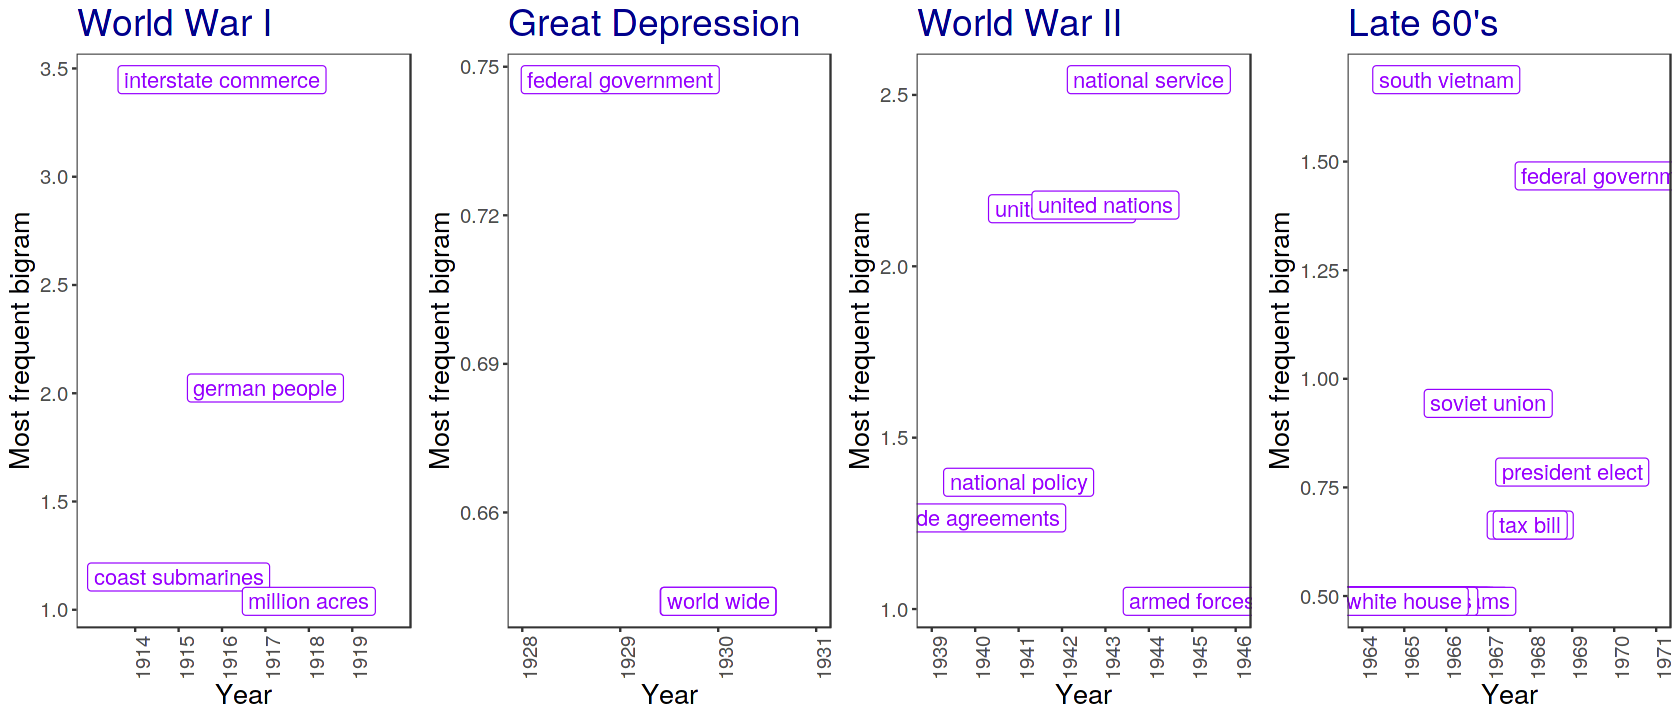

In [19]:
options(repr.plot.width=14, repr.plot.height=6)

WW1 <- ggplot(data=TopBigram[TopBigram$Year > 1914 & TopBigram$Year < 1919, ], aes(x=Year, y=BigramFreq)) +
geom_label(label=TopBigram[TopBigram$Year > 1914 & TopBigram$Year < 1919, ]$bigram,col='#9600ff', size=4.5) +
ggtitle('World War I') + 
scale_x_continuous(breaks=seq(1914, 1919, by=1), limits=c(1913, 1920)) +
ylab('Most frequent bigram') +
theme_bw() + MyTheme

GD <- ggplot(data=TopBigram[TopBigram$Year > 1928 & TopBigram$Year < 1931, ], aes(x=Year, y=BigramFreq)) +
geom_label(label=TopBigram[TopBigram$Year > 1928 & TopBigram$Year < 1931, ]$bigram,col='#9600ff', size=4.5) +
ggtitle('Great Depression') + #xlim(1900, 1940) +
scale_x_continuous(breaks=seq(1928, 1931, by=1), limits=c(1928, 1931)) +
ylab('Most frequent bigram') +
theme_bw() + MyTheme

WW2 <- ggplot(data=TopBigram[TopBigram$Year > 1939 & TopBigram$Year < 1946, ], aes(x=Year, y=BigramFreq)) +
geom_label(label=TopBigram[TopBigram$Year > 1939 & TopBigram$Year < 1946, ]$bigram,col='#9600ff', size=4.5) +
ggtitle('World War II') + #xlim(1900, 1940) +
scale_x_continuous(breaks=seq(1939, 1946, by=1), limits=c(1939, 1946)) +
ylab('Most frequent bigram') +
theme_bw() + MyTheme

GW <- ggplot(data=TopBigram[TopBigram$Year > 1964 & TopBigram$Year < 1971, ], aes(x=Year, y=BigramFreq)) +
geom_label(label=TopBigram[TopBigram$Year > 1964 & TopBigram$Year < 1971, ]$bigram,col='#9600ff', size=4.5) +
ggtitle("Late 60's") + #xlim(1900, 1940) +
scale_x_continuous(breaks=seq(1964, 1971, by=1), limits=c(1964, 1971)) +
ylab('Most frequent bigram') +
theme_bw() + MyTheme


library(gridExtra)
grid.arrange(WW1, GD, WW2, GW,
             ncol=4)

## 5. Focus on the last 4 presidents: top 5 words in each address

In [20]:
Top5 <- FreqList[names(FreqList) %in% ChosenFiles][[1]] %>% top_n(n, n=5) 

for(i in 2:length(ChosenFiles)){
    Temp <- FreqList[names(FreqList) %in% ChosenFiles][[i]] %>% top_n(n, n=5)
    Top5 <- rbind(Top5, Temp)
}


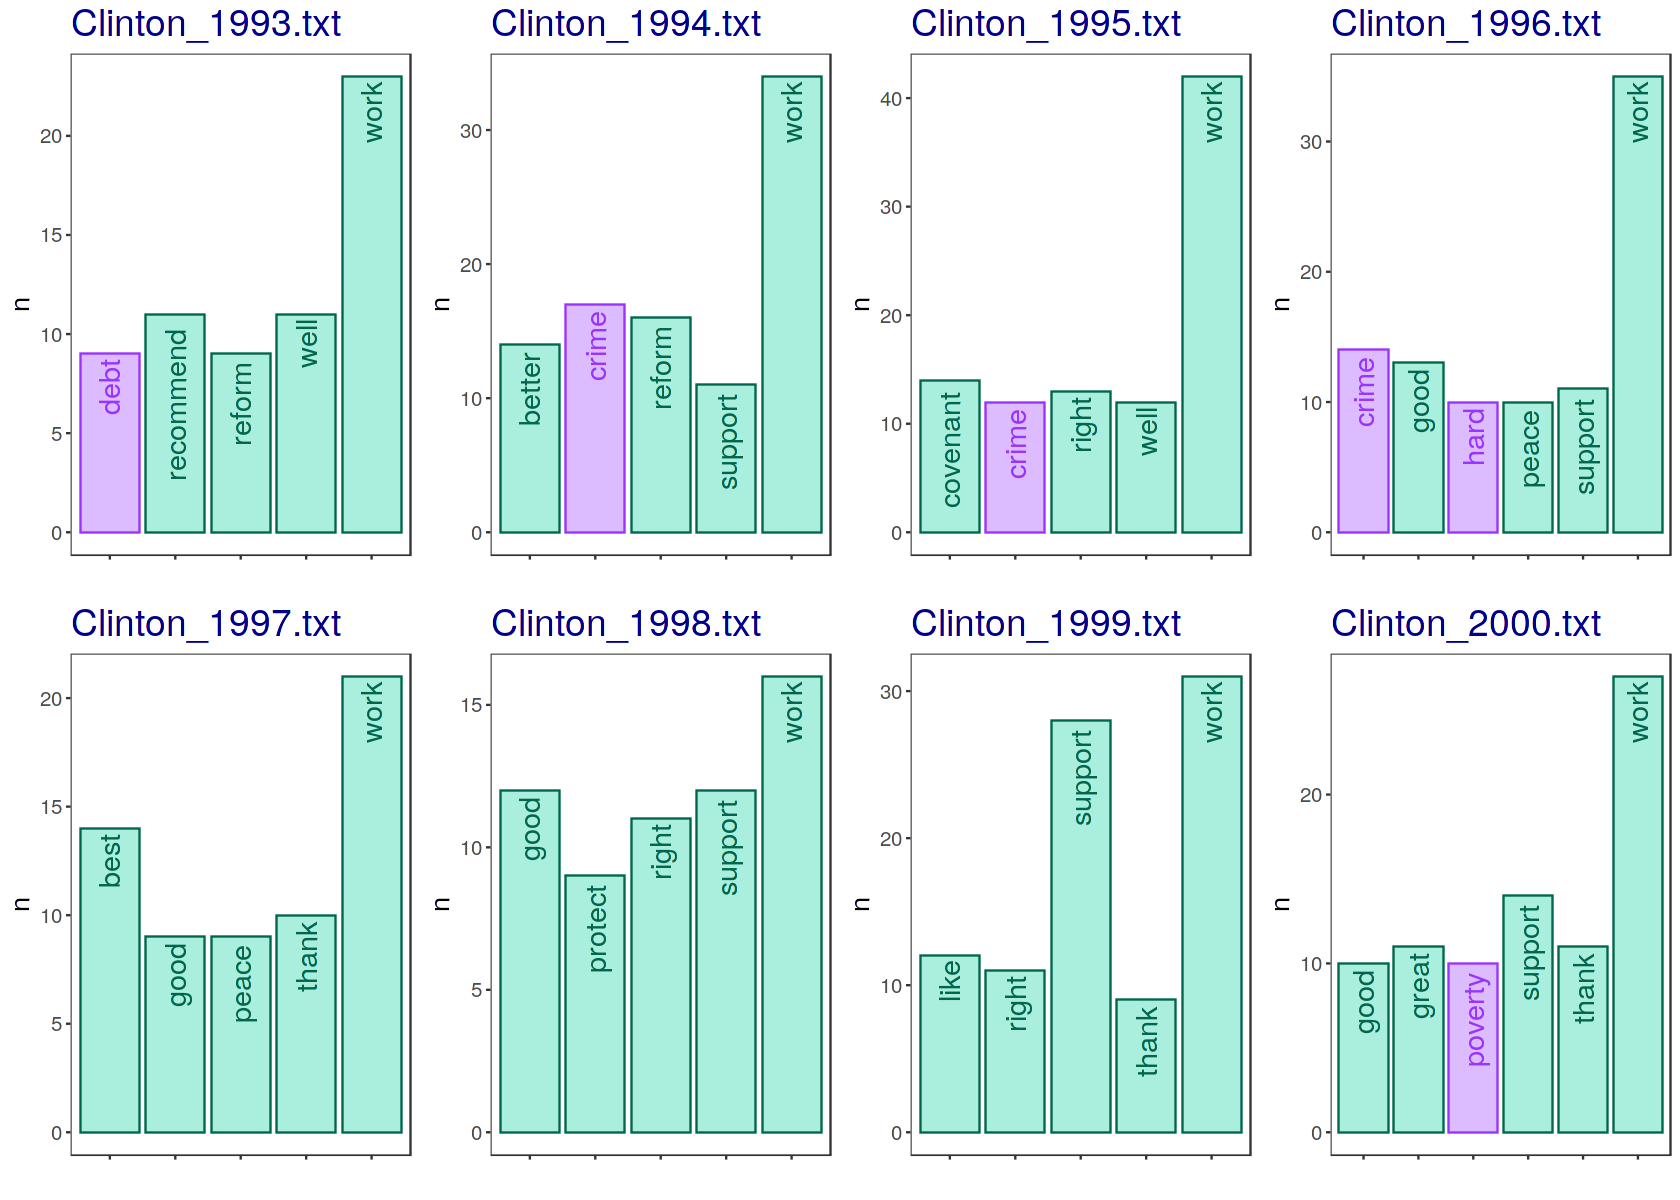

In [21]:
Bar <- list()

Speech <- Top5 %>% pull(Speech) %>% unique
#Speech

for(i in 1:length(Speech)){
    Bar[[i]] <- ggplot(data=Top5[Top5$Speech==Speech[i],], aes(x=word, y=n, fill=sentiment, color=sentiment)) +
    geom_bar(stat='identity') + xlab('') +
    #geom_text(aes(label=Top5$word, x=word, y=1), size=4) +
    geom_text(aes(label = word, hjust=1.1), angle=90, size=6)+
    scale_fill_manual(values=c('positive'='#00cc9955', 'negative'='#9933ff55')) +
    scale_color_manual(values=c('positive'='#00664d', 'negative'='#9933ff')) +
    ggtitle(Speech[i])+ 
    theme_bw() + MyTheme +
    theme(legend.position="") + theme(axis.text.x = element_blank())
}

options(repr.plot.width=14, repr.plot.height=10)
grid.arrange(Bar[[1]], Bar[[2]], Bar[[3]], Bar[[4]],
             Bar[[5]], Bar[[6]], Bar[[7]], Bar[[16]],
             ncol=4, nrow=2)

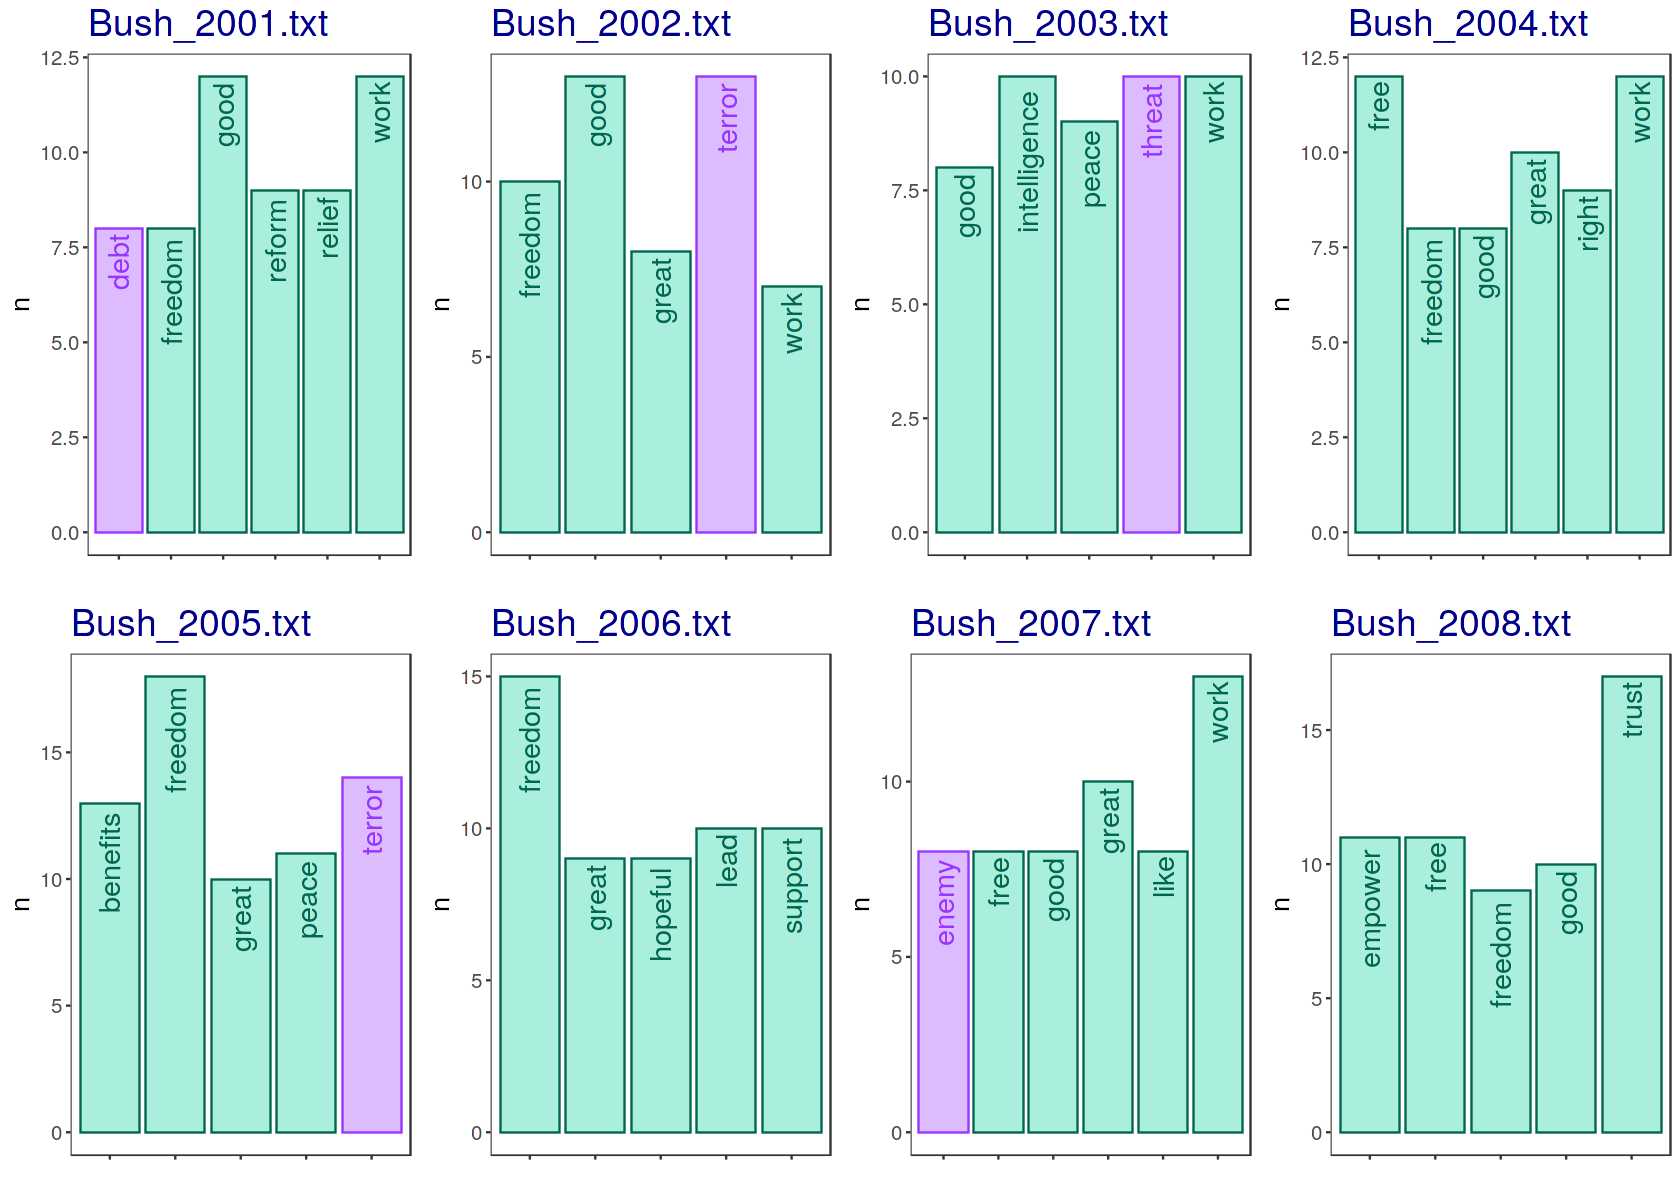

In [22]:
grid.arrange(Bar[[8]], Bar[[9]], Bar[[10]], Bar[[11]],
             Bar[[12]], Bar[[13]], Bar[[14]], Bar[[15]],
             ncol=4, nrow=2)

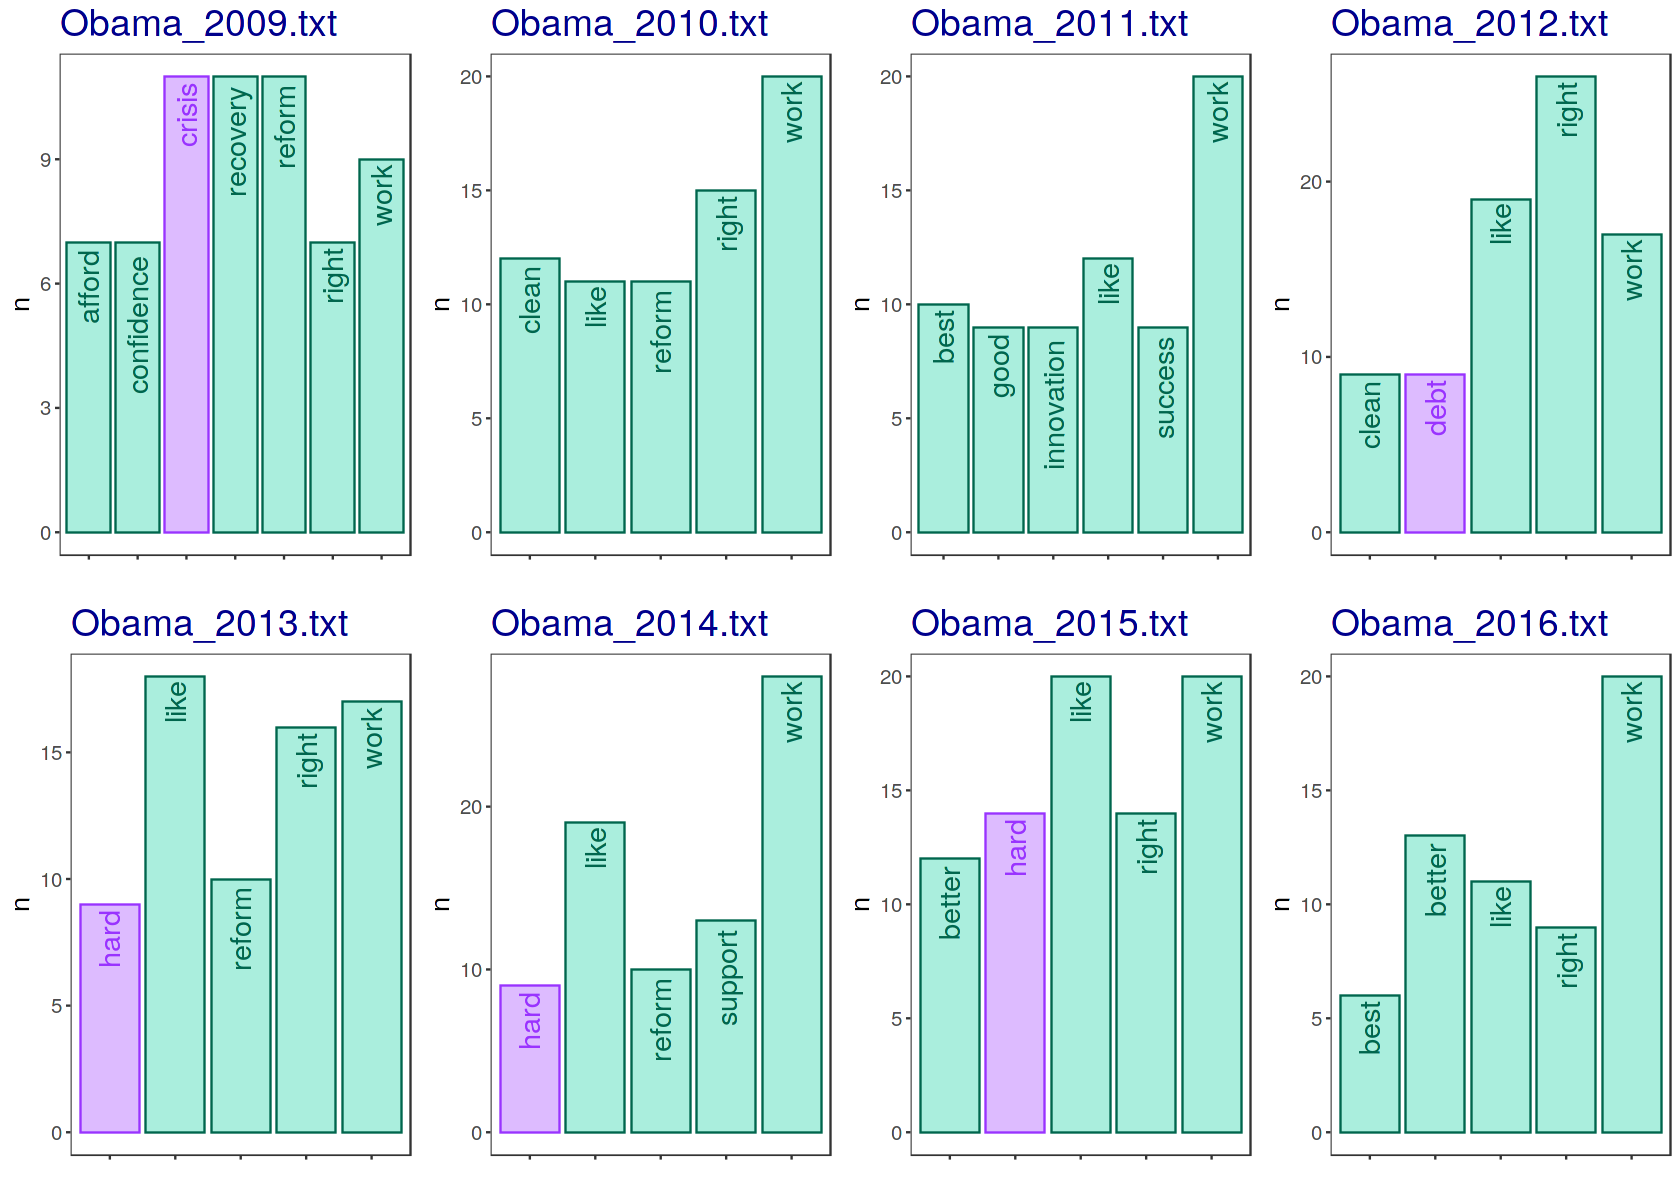

In [23]:
grid.arrange(Bar[[17]], Bar[[18]], Bar[[19]], Bar[[20]],
             Bar[[21]], Bar[[22]], Bar[[23]], Bar[[24]],
             ncol=4, nrow=2)

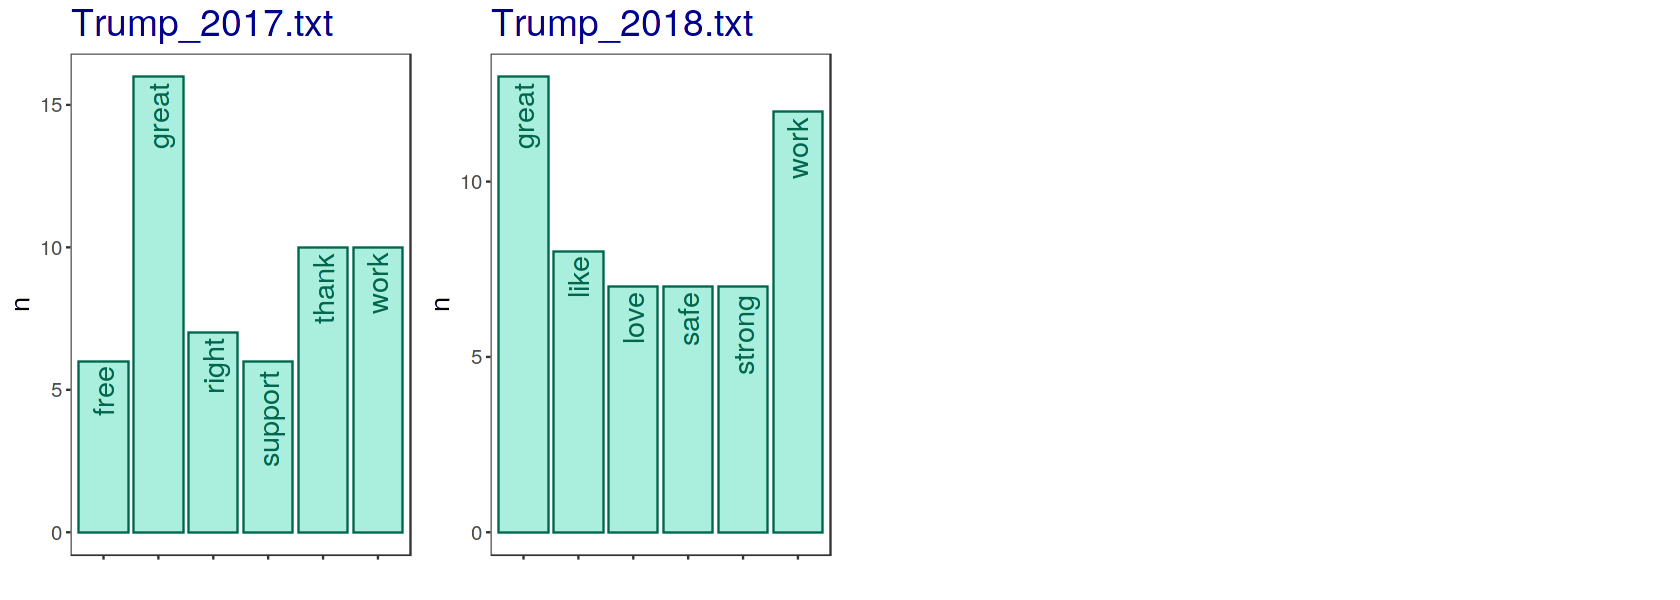

In [24]:
options(repr.plot.width=14, repr.plot.height=5)
grid.arrange(Bar[[25]], Bar[[26]],
             ncol=4)

## 6. Focus on the last 4 presidents: Most frequent bigrams by wordclouds

I explore by wordclouds the most frequent bigrams of a landmark speech for each president. 

### __Clinton 1999 address__

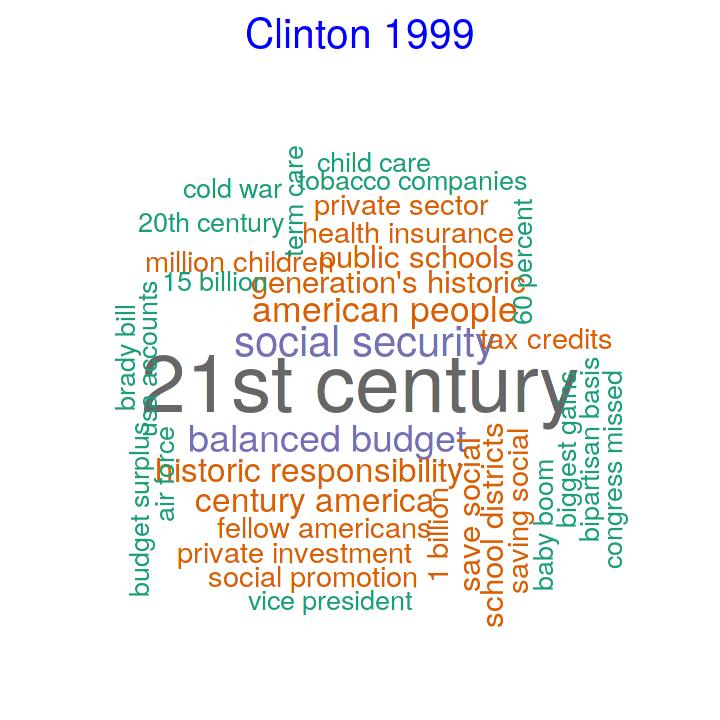

In [25]:
options(repr.plot.width=6, repr.plot.height=6)
layout(matrix(c(1, 2), nrow=2), heights=c(0.5, 5))
par(mar=rep(0, 4))
plot.new()
text(x=0.5, y=0.5, 'Clinton 1999', cex=2, col='blue')
#wordcloud(x, main="Title")

wordcloud(words = FreqBigrams[['Clinton_1999']]$bigram, freq = FreqList[[i]]$n, min.freq = 3,
          max.words=75, random.order=FALSE, rot.per=0.35, scale=c(4,1),
          colors=brewer.pal(8, "Dark2"), main='P')


### __Bush 2002 address__

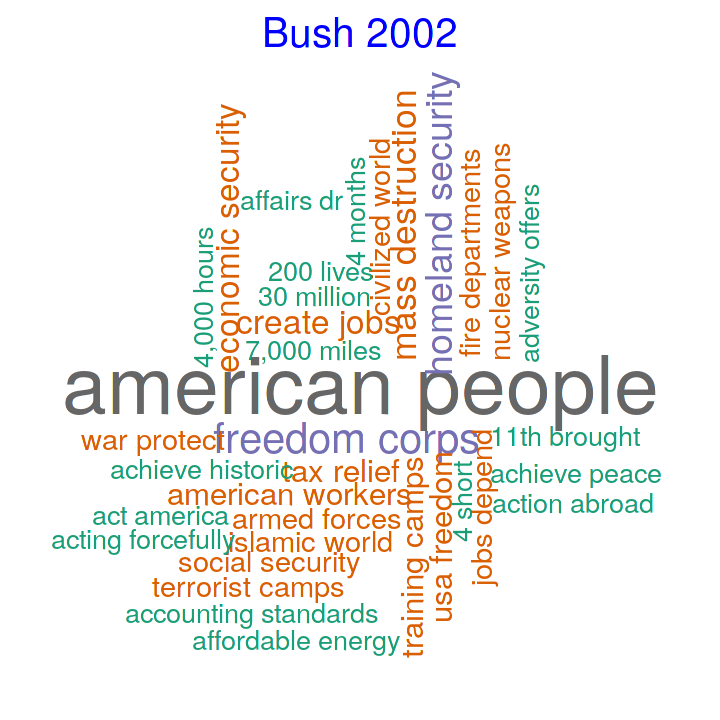

In [26]:
options(repr.plot.width=6, repr.plot.height=6)
layout(matrix(c(1, 2), nrow=2), heights=c(0.5, 5))
par(mar=rep(0, 4))
plot.new()
text(x=0.5, y=0.5, 'Bush 2002', cex=2, col='blue')
#wordcloud(x, main="Title")

wordcloud(words = FreqBigrams[['Bush_2002']]$bigram, freq = FreqList[[i]]$n, min.freq = 3,
          max.words=75, random.order=FALSE, rot.per=0.35, scale=c(4,1),
          colors=brewer.pal(8, "Dark2"), main='P')


### __Obama 2009 address__

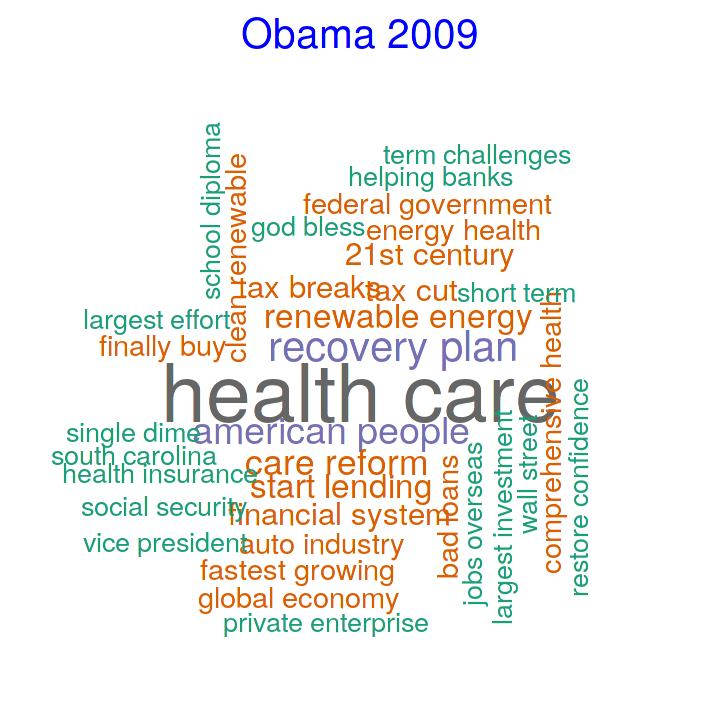

In [27]:
options(repr.plot.width=6, repr.plot.height=6)
layout(matrix(c(1, 2), nrow=2), heights=c(0.5, 5))
par(mar=rep(0, 4))
plot.new()
text(x=0.5, y=0.5, 'Obama 2009', cex=2, col='blue')
#wordcloud(x, main="Title")

wordcloud(words = FreqBigrams[['Obama_2009']]$bigram, freq = FreqList[[i]]$n, min.freq = 3,
          max.words=75, random.order=FALSE, rot.per=0.35, scale=c(4,1),
          colors=brewer.pal(8, "Dark2"), main='P')

### __Trump 2017 address__

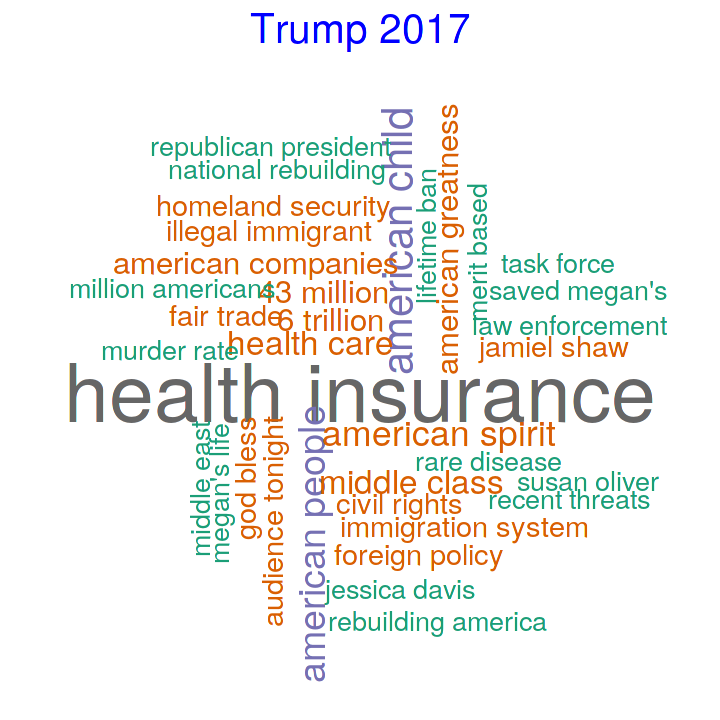

In [28]:
options(repr.plot.width=6, repr.plot.height=6)
layout(matrix(c(1, 2), nrow=2), heights=c(0.5, 5))
par(mar=rep(0, 4))
plot.new()
text(x=0.5, y=0.5, 'Trump 2017', cex=2, col='blue')
#wordcloud(x, main="Title")

wordcloud(words = FreqBigrams[['Trump_2017']]$bigram, freq = FreqList[[i]]$n, min.freq = 3,
          max.words=75, random.order=FALSE, rot.per=0.35, scale=c(4,1),
          colors=brewer.pal(8, "Dark2"), main='P')